<h1> Scaling up ML using Cloud ML Engine </h1>

Adapted from [Notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/cloudmle/cloudmle.ipynb) of Google Coursera Course [Serverless Machine Learning with Tensorflow on Google Cloud Platform](https://www.coursera.org/learn/serverless-machine-learning-gcp/)

In [ ]:
!pip install tensorflow==1.12

In [ ]:
%%bash
source activate gcp_dl
TF_VERSION=$(python3 -c 'import tensorflow as tf; print(tf.__version__)')
if $TF_VERSION != "1.12.0"
then
    pip install tensorflow==1.12
fi
    echo "Found Tensorflow: $TF_VERSION"

In [3]:
import tensorflow as tf
tf.__version__

'1.12.0'

In [1]:
import os
WORKINGDIR = os.getcwd()
folders = WORKINGDIR.split('/')
if folders.pop() == 'notebook':  # or a list: in ['notebook', 'src', etc.]
  WORKINGDIR = '/'.join(folders)
  print("New working directory: {}".format(WORKINGDIR))
else:
  print("Current Working direcotory is kept: {}".format(WORKINGDIR))
os.chdir(WORKINGDIR)

New working directory: /home/enryh/gcp_ml_engine_talk


<h2> Environment variables for project and bucket </h2>

Note that:
<ol>
<li> Your project id is the *unique* string that identifies your project (not the project name). You can find this from the GCP Console dashboard's Home page. My dashboard reads:  
     
     Project ID: ml-productive-pipeline-12345
<li> Cloud training often involves saving and restoring model files. If you don't have a bucket already, I suggest that you create one from the GCP console (because it will dynamically check whether the bucket name you want is available). A common pattern is to prefix the bucket name by the project id, so that it is unique. Also, for cost reasons, you might want to use a single region bucket. </li>
</ol>

<b>Add all detail in to [config.yaml](../config.yaml) file in main directory. Missing in public repository.


In [3]:
import yaml

with open("config.yaml", "r", encoding = "utf8") as f:
    config = yaml.load(f)
    
print(config)

# # #Create config manually and save as yaml:
# config = {}
# config['project-id'] = 'PROJECT'  # # REPLACE WITH YOUR PROJECT ID
# config['region'] = 'europe-west1' # Choose an available region for Cloud MLE from https://cloud.google.com/ml-engine/docs/regions.
# config['bucket'] = 'Bucket-name'  # REPLACE WITH YOUR BUCKET NAME. Use a regional bucket in the region you selected.
# 
# with open("../config_from_python.yaml", 'wb', encoding= 'utf8') as f:
#     yaml.dump(f)

{'project-id': 'ml-productive-pipeline-53122', 'region': 'europe-west1', 'bucket': 'ml-productive-pipeline-53122', 'tf-version': 1.12, 'pkg-name': 'pkg_mnist_fnn'}


In order to persistently add variables to the runtime of the datalab kernel, us the build in python function `os.environ`

In [4]:
import os
PROJECT = config['project-id'] 
REGION = config['region'] # Choose an available region for Cloud MLE from https://cloud.google.com/ml-engine/docs/regions.
BUCKET = config['bucket'] # REPLACE WITH YOUR BUCKET NAME. Use a regional bucket in the region you selected.
PKG_NAME = config['pkg-name']

os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = str(config['tf-version'])  # Tensorflow version 1.4 before
os.environ['PKG_NAME'] = config['pkg-name']

Now, you can access the environement variable in the terminal running this datalab session

In [5]:
%%bash
echo $TFVERSION

1.12


In [6]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


Allow the Cloud ML Engine service account to read/write to the bucket containing training data.

In [ ]:
%%bash
PROJECT_ID=$PROJECT
AUTH_TOKEN=$(gcloud auth print-access-token)
# echo $AUTH_TOKEN
SVC_ACCOUNT=$(curl -X GET -H "Content-Type: application/json" \
    -H "Authorization: Bearer $AUTH_TOKEN" \
    https://ml.googleapis.com/v1/projects/${PROJECT_ID}:getConfig \
    | python -c "import json; import sys; response = json.load(sys.stdin); \
    print(response['serviceAccount'])")
echo "Current Service Account of VM: $SVC_ACCOUNT"
echo "Authorizing the Cloud ML Service account $SVC_ACCOUNT to access files in Bucket: $BUCKET"
gsutil -m defacl ch -u $SVC_ACCOUNT:R gs://$BUCKET
gsutil -m acl ch -u $SVC_ACCOUNT:R -r gs://$BUCKET  # error message (if bucket is empty) can be ignored
gsutil -m acl ch -u $SVC_ACCOUNT:W gs://$BUCKET

<h2> Packaging up the code </h2>

Take your code and put into a standard Python package structure, see  <a href="package_ml_engine/mnist_ml_engine.py">model.py</a>

In [16]:
%pfile src/$PKG_NAME/model.py

Object `src/pkg_mnist_fnn/model.py` not found.


In [63]:
!cat src/$PKG_NAME/task.py

"""
Parse arguments and call main function
"""
import os
import argparse
import shutil

from .model import train_and_evaluate

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--data_path',
        help='GCS or local path to training data',
        required=True
    )
    parser.add_argument(
        '--output_dir',
        help='GCS location to write checkpoints and export models',
        required=True
    )
    parser.add_argument(
        '--train_batch_size',
        help='Batch size for training steps',
        type=int,
        default='128'
    )
    parser.add_argument(
        '--train_steps',
        help='Steps to run the training job for',
        type=int,
        default='200'
    )
    parser.add_argument(
        '--hidden_units',
        help='List of hidden layer sizes to use for DNN feature columns',
        nargs='+',
        type=int,
        default=[128, 64, 32]
    )
    parser.add_argument(
        '--job_dir'

<h2> Find absolute paths to your data </h2>

Note the absolute paths below.
`/content` is mapped in Datalab to where the home icon takes you

In [64]:
%%bash
echo "Working Directory $PWD"
echo "Package Directory $PWD/src/$PKG_NAME"
echo "Saved Model directory to be erased: $PWD/src/$PKG_Name/trained"
rm -rf $PWD/src/$PKG_NAME/trained/

Working Directory /home/enryh/proj_DL_models_and_pipelines_with_GCP
Package Directory /home/enryh/proj_DL_models_and_pipelines_with_GCP/src/pkg_mnist_fnn
Saved Model directory to be erased: /home/enryh/proj_DL_models_and_pipelines_with_GCP/src//trained


<h2> Running the Python module from the command-line </h2>

In [65]:
%%bash
rm -rf $PKG_NAME.tar.gz ${PWD}/$PKG_NAME/trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/../

echo "Python Package Path: src.${PKG_NAME}.task"

python -m src.${PKG_NAME}.task \
   --data_path="${PWD}/data" \
   --output_dir=${PWD}/src/${PKG_NAME}/trained \
   --train_steps=1000 \
   --job_dir=tmp
   
echo "Saved model: ${PWD}/src/${PKG_NAME}/trained/export/exporter/ "

Python Package Path: src.pkg_mnist_fnn.task
['dnn/head/beta1_power', 'dnn/head/beta2_power', 'dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adam', 'dnn/hiddenlayer_0/bias/t_0/Adam_1', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adam', 'dnn/hiddenlayer_0/kernel/t_0/Adam_1', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adam', 'dnn/hiddenlayer_1/bias/t_0/Adam_1', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adam', 'dnn/hiddenlayer_1/kernel/t_0/Adam_1', 'dnn/hiddenlayer_2/bias', 'dnn/hiddenlayer_2/bias/t_0/Adam', 'dnn/hiddenlayer_2/bias/t_0/Adam_1', 'dnn/hiddenlayer_2/kernel', 'dnn/hiddenlayer_2/kernel/t_0/Adam', 'dnn/hiddenlayer_2/kernel/t_0/Adam_1', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adam', 'dnn/logits/bias/t_0/Adam_1', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adam', 'dnn/logits/kernel/t_0/Adam_1', 'global_step']
Saved model: /home/enryh/proj_DL_models_and_pipelines_with_GCP/src/pkg_mnist_fnn/trained/export/exporter/ 


Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
2019-02-18 11:49:15.193946: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-02-18 11:49:15.198531: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.


In [66]:
%%bash
ls $PWD/src/$PKG_NAME/trained/export/exporter/

1550486967


Create an test-image in numpy format saved as json (copy from test set)

In [38]:
import numpy as np
import json
from src.pkg_mnist_fnn.utils import load_data
from src.pkg_mnist_fnn.model import parse_images
(_,_), (x_test, y_test) = load_data(rel_path='data')
N=4
test_indices = np.random.randint(low=0, high=len(y_test), size=N)
x_test, y_test = x_test[test_indices], y_test[test_indices]
x_test = parse_images(x_test).tolist()

Loaded data from /home/enryh/proj_DL_models_and_pipelines_with_GCP/data/mnist.npz


In [39]:
eol = "\r\n"
n_lines = len(y_test)
with open("data/test.json", "w") as f:
    for image, label in zip(x_test, y_test):
        _dict = {"x": image} #, "y": int(label)}
        f.write(json.dumps(_dict) + eol)

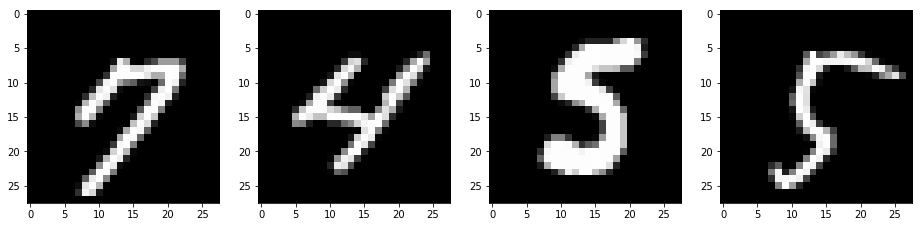

In [40]:
from matplotlib import pyplot as plt
import numpy as np
import json
with open("data/test.json", "r") as f:
    images = f.readlines()
plt.figure(figsize=(20,4))
for i, image in enumerate(images):
    if i < 4:
        image = json.loads(image)
        image = np.array(image['x'])
        plt.subplot(1, 5, i+1)
        plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)

In [ ]:
!ls /usr/lib/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/

In order to work with `Python 3`, delete the `*.pyc` files, see [post](https://stackoverflow.com/questions/48824381/gcloud-ml-engine-local-predict-runtimeerror-bad-magic-number-in-pyc-file)

Default Datalab
```
rm /tools/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/*.pyc
```
Default UNIX:
```
sudo rm /usr/lib/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/*.pyc
```

> Process running Datalab or Jupyter Notebook needs admin rights. This is not always given for locally run notebooks

In [ ]:
%%bash
# #remove any pyc files: Using Python3 you have to recompile
# #Note: you need admin rights
rm /tools/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/*.pyc
# sudo rm /usr/lib/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/*.pyc 

In [41]:
%%bash
model_dir=$(ls $PWD/src/$PKG_NAME/trained/export/exporter/)
echo "Selected Model:  $model_dir"
gcloud ml-engine local predict \
    --model-dir=${PWD}/src/$PKG_NAME/trained/export/exporter/${model_dir} \
    --json-instances=./data/test.json \
    --verbosity debug > data/test_predictions
cat data/test_predictions

Selected Model:  1550484398
CLASS_IDS  CLASSES  LOGITS                                                                                                                                                                                                        PROBABILITIES
[4]        [u'4']   [0.2955600619316101, -1.395798683166504, -1.8033928871154785, -0.07336592674255371, 4.363767623901367, 1.0356162786483765, -3.5050811767578125, 1.4503240585327148, 0.24793429672718048, 3.1991055011749268]  [0.011773805133998394, 0.0021695473697036505, 0.001443288754671812, 0.008141309022903442, 0.6882036924362183, 0.024678530171513557, 0.0002632203104440123, 0.037361521273851395, 0.011226214468479156, 0.2147388756275177]
[9]        [u'9']   [-0.6732280850410461, -5.111705780029297, -1.8348519802093506, -0.9554049372673035, 1.238022804260254, 0.11140099167823792, -5.326626777648926, 1.729777216911316, -0.345848023891449, 3.9755911827087402]    [0.007815743796527386, 9.233446326106787e-05, 0.0024461532011

DEBUG: Running [gcloud.ml-engine.local.predict] with arguments: [--json-instances: "./data/test.json", --model-dir: "/home/enryh/proj_DL_models_and_pipelines_with_GCP/src/pkg_mnist_fnn/trained/export/exporter/1550484398", --verbosity: "debug"]
2019-02-18 11:20:57.335174: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.

INFO: Display format: "default 
          table(
              predictions:format="table(
                  class_ids, classes, logits, probabilities
              )"
          )"
DEBUG: SDK update checks are disabled.


In [36]:
print(y_test)

[4 9 2 5]


In [37]:
%%bash
gcloud ml-engine local predict --help

NAME
    gcloud ml-engine local predict - run prediction locally

SYNOPSIS
    gcloud ml-engine local predict --model-dir=MODEL_DIR
        (--json-instances=JSON_INSTANCES | --text-instances=TEXT_INSTANCES)
        [--framework=FRAMEWORK] [--signature-name=SIGNATURE_NAME]
        [GCLOUD_WIDE_FLAG ...]

DESCRIPTION
    gcloud ml-engine local predict performs prediction locally with the given
    instances. It requires the TensorFlow SDK be installed locally. The output
    format mirrors gcloud ml-engine predict (online prediction)

REQUIRED FLAGS
     --model-dir=MODEL_DIR
        Path to the model.

     Exactly one of these must be specified:

       --json-instances=JSON_INSTANCES
          Path to a local file from which instances are read. Instances are in
          JSON format; newline delimited.

          An example of the JSON instances file:

              {"images": [0.0, ..., 0.1], "key": 3}
              {"images": [0.0, ..., 0.1], "key": 2}
              ...

          

<h2> Running locally using gcloud </h2>

In [42]:
%%bash
# rm -rf taxifare.tar.gz taxi_trained
gcloud ml-engine local train \
   --module-name=${PKG_NAME}.task \
   --package-path=${PWD}/src/${PKG_NAME} \
   -- \
   --data_path="${PWD}/data" \
   --output_dir=${PWD}/src/${PKG_NAME}/trained \
   --train_steps=500 \
   --job_dir=./tmp

['dnn/head/beta1_power', 'dnn/head/beta2_power', 'dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adam', 'dnn/hiddenlayer_0/bias/t_0/Adam_1', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adam', 'dnn/hiddenlayer_0/kernel/t_0/Adam_1', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adam', 'dnn/hiddenlayer_1/bias/t_0/Adam_1', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adam', 'dnn/hiddenlayer_1/kernel/t_0/Adam_1', 'dnn/hiddenlayer_2/bias', 'dnn/hiddenlayer_2/bias/t_0/Adam', 'dnn/hiddenlayer_2/bias/t_0/Adam_1', 'dnn/hiddenlayer_2/kernel', 'dnn/hiddenlayer_2/kernel/t_0/Adam', 'dnn/hiddenlayer_2/kernel/t_0/Adam_1', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adam', 'dnn/logits/bias/t_0/Adam_1', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adam', 'dnn/logits/kernel/t_0/Adam_1', 'global_step']


Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
2019-02-18 11:21:45.778736: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-02-18 11:21:45.785785: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.


### Visualise in TensorBoard

In Datalab Tensorboard is available using a special package. On your local machine, you can execute tensorflow using the command line.

DATALAB:

In [ ]:
from google.datalab.ml import TensorBoard
TensorBoard().start(('{}/'+os.environ['PKG_NAME']).format(os.environ['PWD']))

In [ ]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print('Stopped TensorBoard with pid {}'.format(pid))

Local Machine: 

In [96]:
!tensorboard --logdir $PWD/src/$PKG_NAME/trained

W0218 13:54:57.334849 Reloader tf_logging.py:120] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0218 13:54:57.334848 140204896913152 tf_logging.py:120] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0218 13:54:57.335278 Reloader tf_logging.py:120] Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
W0218 13:54:57.335278 140204896913152 tf_logging.py:120] Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
TensorBoard 1.12.0 at http://enryh:6006 (Press CTRL+C to quit)
^C


If the above step (to stop TensorBoard) appears stalled, just move on to the next step. You don't need to wait for it to return.

<h2> Submit training job using gcloud </h2>

First copy the training data to the cloud.  Then, launch a training job.

After you submit the job, go to the cloud console (http://console.cloud.google.com) and select <b>Machine Learning | Jobs</b> to monitor progress.  

<b>Note:</b> Don't be concerned if the notebook stalls (with a blue progress bar) or returns with an error about being unable to refresh auth tokens. This is a long-lived Cloud job and work is going on in the cloud.  Use the Cloud Console link (above) to monitor the job.

In [71]:
!gsutil -m rm -rf gs://$BUCKET/$PKG_NAME/*

CommandException: 1 files/objects could not be removed.


In [72]:
steps = 10000
batch_size = 128
n_train = 60000
print("Number of epochs using {} steps: {:.1f}".format(steps, steps * batch_size / n_train))
steps = int(60000 / 128 * 10) + 1
print("For ten epochs specify {} steps".format(steps))

Number of epochs using 10000 steps: 21.3
For ten epochs specify 4688 steps


In [93]:
OUTDIR = '/'.join(['gs:/', BUCKET, PKG_NAME, 'trained'])
os.environ['OUTDIR'] = OUTDIR

In [87]:
%%bash

OUTDIR=gs://${BUCKET}/$PKG_NAME/trained
JOBNAME=mnist_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=$PKG_NAME.task \
   --package-path=${PWD}/src/$PKG_NAME \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC \
   --python-version 3.5 \
   --runtime-version=$TFVERSION \
   -- \
   --data_path="gs://${BUCKET}/$PKG_NAME/" \
   --output_dir=$OUTDIR \
   --train_steps=5000 \
   --job_dir=$OUTDIR/jobs 

Process is interrupted.


In [74]:
%%bash
gcloud ml-engine jobs describe    mnist_190218_105007
gcloud ml-engine jobs stream-logs mnist_190218_105007

createTime: '2019-02-18T10:50:11Z'
etag: vvITuWEjDLQ=
jobId: mnist_190218_105007
startTime: '2019-02-18T10:50:59Z'
state: RUNNING
trainingInput:
  args:
  - --data_path=gs://ml-productive-pipeline-53122/pkg_mnist_fnn/
  - --output_dir=gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained
  - --train_steps=5000
  - --job_dir=gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/jobs
  packageUris:
  - gs://ml-productive-pipeline-53122/mnist_190218_105007/cac4d120b8857d8007d507feb554bfa3f8c883df822b1a7e4ef5e547e84f4088/pkg_mnist_fnn-0.0.0.tar.gz
  pythonModule: pkg_mnist_fnn.task
  pythonVersion: '3.5'
  region: europe-west1
  runtimeVersion: '1.12'
trainingOutput: {}
INFO	2019-02-18 11:50:11 +0100	service		Validating job requirements...
INFO	2019-02-18 11:50:11 +0100	service		Job creation request has been successfully validated.
INFO	2019-02-18 11:50:11 +0100	service		Job mnist_190218_105007 is queued.
INFO	2019-02-18 11:50:12 +0100	service		Waiting for job to be provisioned.
INFO	2


View job in the Cloud Console at:
https://console.cloud.google.com/ml/jobs/mnist_190218_105007?project=ml-productive-pipeline-53122

View logs at:
https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fmnist_190218_105007&project=ml-productive-pipeline-53122


Don't be concerned if the notebook appears stalled (with a blue progress bar) or returns with an error about being unable to refresh auth tokens. This is a long-lived Cloud job and work is going on in the cloud. 

<b>Use the Cloud Console link to monitor the job and do NOT proceed until the job is done.</b>

##### Check Results using TensorBoard

In [94]:
%%bash
#gcloud auth application-default login
echo $OUTDIR
#tensorboard --logdir $OUTDIR

gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained


<h2> Deploy model </h2>

Find out the actual name of the subdirectory where the model is stored and use it to deploy the model.  Deploying model will take up to <b>5 minutes</b>.

In [ ]:
%%bash
gsutil ls gs://${BUCKET}/$PKG_NAME/trained/export/exporter

In [ ]:
%%bash
MODEL_NAME="MNIST_MLENGINE"
MODEL_VERSION="v1"
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/$PKG_NAME/trained/export/exporter | tail -1)
echo "Run these commands one-by-one (the very first time, you'll create a model and then create a version)"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models   create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version $TFVERSION

<h2> Prediction </h2>

In [3]:
%%bash
gcloud ml-engine predict --model=MNIST_MLENGINE --version=v1 --json-instances=data/test.json

CLASS_IDS  CLASSES  LOGITS                                                                                                                                                                                                       PROBABILITIES
[8]        [u'8']   [-1.3327929973602295, 2.2530980110168457, 3.4556188583374023, 5.9954352378845215, 0.09868371486663818, 3.893829345703125, 3.669095754623413, 2.418844699859619, 11.398612022399902, 4.405415058135986]       [2.9361999622778967e-06, 0.00010595430649118498, 0.00035266843042336404, 0.004470898769795895, 1.2287626304896548e-05, 0.0005466117872856557, 0.0004365947679616511, 0.00012505512859206647, 0.9930353164672852, 0.0009117123554460704]
[5]        [u'5']   [-15.63167953491211, 0.5527050495147705, -10.781968116760254, 31.3237247467041, -1.7304039001464844, 47.42430114746094, 9.034704208374023, -9.172748565673828, 25.79246711730957, 28.165958404541016]        [4.122260934448926e-28, 4.404776747626436e-21, 5.264277745420179e-26, 1.0176734

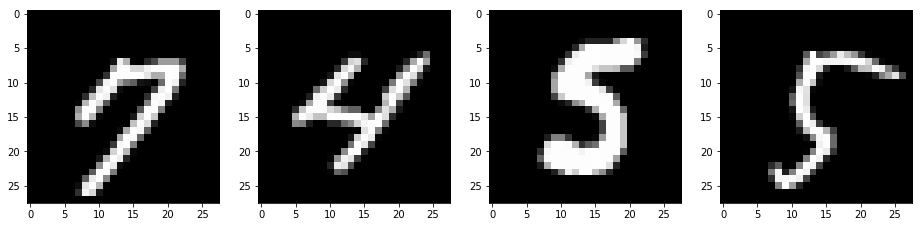

In [41]:
from matplotlib import pyplot as plt
import numpy as np
import json
with open("data/test.json", "r") as f:
    images = f.readlines()
plt.figure(figsize=(20,4))
for i, image in enumerate(images):
    if i < 4:
        image = json.loads(image)
        image = np.array(image['x'])
        plt.subplot(1, 5, i+1)
        plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)

Unfortunatly, we do not have a True Positve. ToDO: Add more examples!

Get predictions using the [Python-Client-Library, see Tutorial](https://cloud.google.com/ml-engine/docs/tensorflow/python-client-library). Since we have created and deployed a model already, we use the [`predict`](https://cloud.google.com/ml-engine/reference/rest/v1/projects) Method instead of `create` as in the documentation. 

[API-Reference](https://cloud.google.com/ml-engine/reference/rest/)

If you need a service account authentification, please follow [this link]() and uncomment the celllines after this cell.

In [ ]:
# %bash
# export GOOGLE_APPLICATION_CREDENTIALS=$PWD/ML-productive-pipeline-53122-64d3c31786e7.json
# echo $GOOGLE_APPLICATION_CREDENTIALS

In [ ]:
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/datalab/proj_DL_models_and_pipelines_with_GCP/notebook/../ML-productive-pipeline-53122-64d3c31786e7.json'

In [7]:
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors
import json

In [8]:
%pdoc discovery.build

```
Signature: discovery.build(serviceName, version, http=None, discoveryServiceUrl='https://www.googleapis.com/discovery/v1/apis/{api}/{apiVersion}/rest', developerKey=None, model=None, requestBuilder=<class 'googleapiclient.http.HttpRequest'>, credentials=None, cache_discovery=True, cache=None)
Docstring:
Construct a Resource for interacting with an API.

Construct a Resource object for interacting with an API. The serviceName and
version are the names from the Discovery service.

Args:
serviceName: string, name of the service.
version: string, the version of the service.
http: httplib2.Http, An instance of httplib2.Http or something that acts
like it that HTTP requests will be made through.
discoveryServiceUrl: string, a URI Template that points to the location of
the discovery service. It should have two parameters {api} and
{apiVersion} that when filled in produce an absolute URI to the discovery
document for that service.
developerKey: string, key obtained from
https://code.google.com/apis/console.
model: googleapiclient.Model, converts to and from the wire format.
requestBuilder: googleapiclient.http.HttpRequest, encapsulator for an HTTP
request.
credentials: oauth2client.Credentials or
google.auth.credentials.Credentials, credentials to be used for
authentication.
cache_discovery: Boolean, whether or not to cache the discovery doc.
cache: googleapiclient.discovery_cache.base.CacheBase, an optional
cache object for the discovery documents.

Returns:
A Resource object with methods for interacting with the service.
File: /usr/local/envs/py3env/lib/python3.5/site-packages/googleapiclient/discovery.py
Type: function
```

In [9]:
api = discovery.build(serviceName='ml', version='v1',
                      http=None, 
                      discoveryServiceUrl='https://www.googleapis.com/discovery/v1/apis/{api}/{apiVersion}/rest', 
                      developerKey=None, 
                      model=None, 
                      #requestBuilder=<class 'googleapiclient.http.HttpRequest'>, 
                      credentials=None, 
                      cache_discovery=True, 
                      cache=None)

/home/enryh/miniconda3/envs/gcp_dl/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [10]:
api

In [11]:
MODEL_NAME = 'MNIST_MLENGINE'
VERSION = 'v1'

In [43]:
from src.pkg_mnist_fnn.utils import load_data
from src.pkg_mnist_fnn.model import parse_images
(_,_), (x_test, y_test) = load_data(rel_path='data')
N=4
test_indices = np.random.randint(low=0, high=len(y_test), size=N)
x_test, y_test = x_test[test_indices], y_test[test_indices]
x_test = parse_images(x_test).tolist()

eol = "\r\n"
n_lines = len(y_test)
instances = []
with open("data/test.json", "r") as f:
    for image, label in zip(x_test, y_test):
        instances.append({"x": image}) #, "y": int(label)}

Loaded data from /home/enryh/proj_DL_models_and_pipelines_with_GCP/data/mnist.npz


In [44]:
type(instances)

list

In [45]:
project_id = 'projects/{}/models/{}/versions/{}'.format(PROJECT, MODEL_NAME, VERSION)
request_data = {"instances":
    instances
}
request = api.projects().predict(body=request_data, name=project_id).execute()
print(request)

{'predictions': [{'probabilities': [5.713608335540272e-16, 1.0, 1.3980798940424477e-12, 4.7910243176428484e-18, 5.213703600792652e-12, 2.4374503316831485e-16, 4.583709178092025e-19, 1.8915770283456368e-08, 7.380032140957837e-10, 4.496945562576364e-16], 'class_ids': [1], 'classes': ['1'], 'logits': [-2.9880850315093994, 32.11042404174805, 4.8145036697387695, -7.769362449645996, 6.1306939125061035, -3.839984893798828, -10.116183280944824, 14.327154159545898, 11.083351135253906, -3.227539539337158]}, {'probabilities': [7.197160556415838e-08, 7.433108635268582e-07, 6.9033926592965145e-06, 7.828126032593738e-14, 0.9998289346694946, 9.057208108509407e-14, 2.4880728233256377e-07, 0.00015889573842287064, 2.965273138144653e-09, 4.127837200940121e-06], 'class_ids': [4], 'classes': ['4'], 'logits': [10.880867958068848, 13.215709686279297, 15.444363594055176, -2.8506062030792236, 27.32769012451172, -2.704768657684326, 12.1212739944458, 18.580598831176758, 7.691564083099365, 14.93010425567627]}, {'

In [50]:
for i, pred in enumerate(request['predictions']):
    print("Predicted class: {}, True Class:\t{}".format(pred['classes'][0], y_test[i]))

Predicted class: 1, True Class:	1
Predicted class: 4, True Class:	4
Predicted class: 5, True Class:	5
Predicted class: 0, True Class:	0


In [46]:
y_test

array([1, 4, 5, 0], dtype=uint8)

In [16]:
project_id = 'projects/{}/models/{}/versions/{}'.format(PROJECT, MODEL_NAME, VERSION)
request_data = {"instances":
  [
   {"x": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3294117748737335, 0.7254902124404907, 0.6235294342041016, 0.5921568870544434, 0.23529411852359772, 0.1411764770746231, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8705882430076599, 0.9960784316062927, 0.9960784316062927, 0.9960784316062927, 0.9960784316062927, 0.9450980424880981, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.7764706015586853, 0.6666666865348816, 0.20392157137393951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26274511218070984, 0.4470588266849518, 0.2823529541492462, 0.4470588266849518, 0.6392157077789307, 0.8901960849761963, 0.9960784316062927, 0.8823529481887817, 0.9960784316062927, 0.9960784316062927, 0.9960784316062927, 0.9803921580314636, 0.8980392217636108, 0.9960784316062927, 0.9960784316062927, 0.5490196347236633, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666667014360428, 0.25882354378700256, 0.054901961237192154, 0.26274511218070984, 0.26274511218070984, 0.26274511218070984, 0.23137255012989044, 0.08235294371843338, 0.9254902005195618, 0.9960784316062927, 0.4156862795352936, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32549020648002625, 0.9921568632125854, 0.8196078538894653, 0.07058823853731155, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08627451211214066, 0.9137254953384399, 1.0, 0.32549020648002625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5058823823928833, 0.9960784316062927, 0.9333333373069763, 0.1725490242242813, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23137255012989044, 0.9764705896377563, 0.9960784316062927, 0.24313725531101227, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686559677124, 0.9960784316062927, 0.7333333492279053, 0.019607843831181526, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03529411926865578, 0.8039215803146362, 0.9725490212440491, 0.22745098173618317, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4941176474094391, 0.9960784316062927, 0.7137255072593689, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29411765933036804, 0.9843137264251709, 0.9411764740943909, 0.2235294133424759, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07450980693101883, 0.8666666746139526, 0.9960784316062927, 0.6509804129600525, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0117647061124444, 0.7960784435272217, 0.9960784316062927, 0.8588235378265381, 0.13725490868091583, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14901961386203766, 0.9960784316062927, 0.9960784316062927, 0.3019607961177826, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12156862765550613, 0.8784313797950745, 0.9960784316062927, 0.45098039507865906, 0.003921568859368563, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686559677124, 0.9960784316062927, 0.9960784316062927, 0.20392157137393951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.239215686917305, 0.9490196108818054, 0.9960784316062927, 0.9960784316062927, 0.20392157137393951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098054409027, 0.9960784316062927, 0.9960784316062927, 0.8588235378265381, 0.1568627506494522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098054409027, 0.9960784316062927, 0.8117647171020508, 0.07058823853731155, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
  ]
}
request = api.projects().predict(body=request_data, name=project_id).execute()
print(request)

{'predictions': [{'probabilities': [0.07440567761659622, 0.06085335463285446, 0.0796218290925026, 0.09449440240859985, 0.0755155086517334, 0.08171500265598297, 0.06408874690532684, 0.07522281259298325, 0.28817883133888245, 0.10590385645627975], 'class_ids': [8], 'classes': ['8'], 'logits': [-0.11568695306777954, -0.31675225496292114, -0.047930844128131866, 0.12332145869731903, -0.10088106244802475, -0.021981418132781982, -0.2649504244327545, -0.10476464033126831, 1.2383620738983154, 0.23731258511543274]}]}
